## RF Deep Learning - Modulation Classification
Exploring ways to exploit Radio Frequency (RF) data using deep learning. This tutorial looks at using complex-valued samples for modulation recognitions and signal classification. The I & Q values of each sample are treated seperately in this tutorial. In the next tutorial, I will show methods for using complex-valued activation functions and operations in neural networks. 

You should study the following references:

[1] [Convolutional Radio Modulation Recognition Networks](https://arxiv.org/abs/1602.04105)

[2] [Modulation Recognition Using Deep Learning](https://blog.kickview.com/modulation-recognition-using-deep-learning/)

[3] [Signal Detection Using Deep Learning](https://blog.kickview.com/signal-detection-using-deep-learning/)


In [1]:
# Imports
from sklearn.metrics import classification_report, confusion_matrix
from RFDataReader import RFDataReader
#from RFNN import *
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pickle
from pprint import *
import os

In [2]:
from tensorflow.python.keras import metrics
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.layers import Input, Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.python.keras.layers import concatenate, multiply, BatchNormalization, ReLU, Softmax,ZeroPadding2D,Reshape
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import model_from_json

In [3]:
tf.__version__

'1.14.0'

In [4]:
#tf.enable_eager_execution()

In [5]:
plt.rcParams["figure.figsize"] = (12,8)  # adjusting plot sizes in notebook

In [6]:
# Datasets are avilable at https://www.deepsig.io/datasets
dataFile = '/dml/notebooks/datasets/RML2016.10a_dict.pkl'

In [7]:
# with open(dataFile, 'rb') as f:
#     data= pickle.load(f, encoding='latin1') 

In [8]:
# Setup important parameters of the data
sampleRate = 1e6 # input sample rate of dataset

In [9]:
# Create RFDataReader object to read in and parse the data
# This will display some info about the data to the console
RFData = RFDataReader(dataFile, sampleRate)


Modulation types present in data:

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']

SNR ranges for each modulation type in data:

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [10]:
# Specify which SNR ranges for input dataset processing
SNRs = range(-14, 20, 2) # SNR ranges to use in data processing

In [11]:
# Specify which modulations to look at for input dataset processing
MODs = ['AM-DSB', 'AM-SSB', 'WBFM', '8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
#MODs = ['BPSK', 'WBFM', '8PSK']

In [12]:
# Specify what the output labels should be
outputClasses = MODs
LABELs = range(0, len(MODs))
inputDim = [128, 2]
numOutputClasses = len(outputClasses)

In [13]:
# Create training and testing data sets
RFData.create_train_and_test_sets(trainingRatio=0.5, snrs_used=SNRs,
                                    mods_used=MODs, outputClasses=outputClasses,
                                    labels=LABELs, normalize=True)

Creating training and testing data sets...

Modulation:  AM-DSB
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  AM-SSB
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  WBFM
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  8PSK
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  BPSK
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  CPFSK
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  GFSK
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  PAM4
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  QAM16
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  QAM64
Number of training samples:  8500
Number of testing samples:  8500

Modulation:  QPSK
Number of training samples:  8500
Number of testing samples:  8500



In [14]:
print('Training data shape: ', RFData.trainIandQ.shape)
print('Testing data shape: ',RFData.testIandQ.shape)
in_shp = RFData.trainIandQ.shape[1:]
print('Input shape = :', in_shp)

Training data shape:  (93500, 2, 128)
Testing data shape:  (93500, 2, 128)
Input shape = : (2, 128)


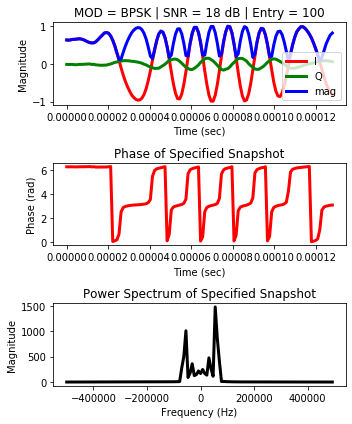

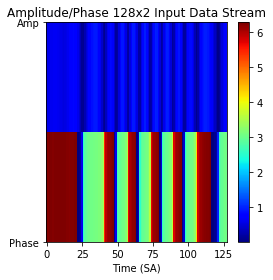

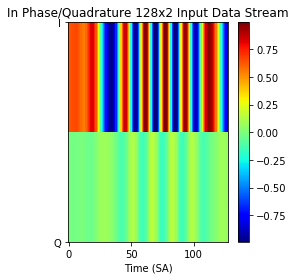

In [15]:
RFData.snapPlot('BPSK', 18, 100, normalize=True)
# RFData.snapPlot('WBFM', 18, 10, normalize=True)
# RFData.snapPlot('8PSK', 18, 100, normalize=True)

In [16]:
RFData.outputClasses

['AM-DSB',
 'AM-SSB',
 'WBFM',
 '8PSK',
 'BPSK',
 'CPFSK',
 'GFSK',
 'PAM4',
 'QAM16',
 'QAM64',
 'QPSK']

In [17]:
#RF data generator 
def RFdata_generator(rfdata, mode, data_type, batch_size):
    
    while True:

        # Select what kind of data to process
        if data_type == 'IandQ':
            if mode == 'train':
                data = RFData.trainIandQ
                num_samples = RFData.trainIandQ.shape[0]
            elif mode == 'test':
                data = RFData.testIandQ
                num_samples = RFData.testIandQ.shape[0]
        elif data_type == 'AmpPhase':
            if mode == 'train':
                data = RFData.trainAmpPhase
                num_samples = RFData.trainAmpPhase.shape[0]
            elif mode == 'test':
                data = RFData.testAmpPhase
                num_samples = RFData.testAmpPhase.shape[0]

        if mode == 'train':
            labels = RFData.trainOutLabels
        elif mode == 'test':
            labels = RFData.testOutLabels
        

        # Go through the data in batches
        for idx in range(0, num_samples-batch_size, batch_size):   
            # Compute start and end indices
            start_idx = idx
            end_idx = idx + batch_size
            local_batch_size = end_idx - start_idx
            #print('Start idx = :', start_idx)
            #print('End idx = :', end_idx)
            #print('Local batch size = :', local_batch_size)

            # Get data for this training batch
            dataBatch = data[start_idx:end_idx,:,:]
            
            # Get labels for this training batch
            labelBatch = np.zeros((local_batch_size, numOutputClasses))
            for samp in range(start_idx, end_idx):
                labelBatch[samp - start_idx, int(labels[samp])] = 1

            data_x = dataBatch
            #data_x = np.expand_dims(data_x,axis  = 1)
            data_y = labelBatch
            yield(data_x, data_y)

In [18]:
# Define our Deep Neural Network
def RFNet():  
              
    model = Sequential()
    model.add(Reshape((2,128,1), input_shape = in_shp))
    model.add(ZeroPadding2D((0,2)))        
    model.add(Conv2D(256, (1, 3), activation='relu', kernel_initializer = 'glorot_uniform', padding = 'valid'))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D((0,2)))
    model.add(Conv2D(80, (2, 3), activation='relu', kernel_initializer = 'glorot_uniform', padding = 'valid'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    #model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    #model.add(Dropout(0.7))
    model.add(Dense(numOutputClasses, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    model.add(Reshape([numOutputClasses])) 
      
    return model

In [19]:
model = RFNet()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 2, 132, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 134, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 132, 80)        122960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 132, 80)        0

In [21]:
from tensorflow.python.keras.optimizers import Adam
#from tensorflow.python.keras.optimizers import SGD

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)  # lr = learning rate for the optimizer
#optimizer = SGD(lr=0.0001, momentum=0.9)

In [22]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
num_epochs = 60
batch_size = 1024
data_type = 'IandQ'
#inputShape = inputDim[0] * inputDim[1]
num_of_train_samples = RFData.trainIandQ.shape[0]
num_of_test_samples = RFData.testIandQ.shape[0]

In [24]:
train_gen = RFdata_generator(RFData,'train','IandQ',batch_size)

test_gen = RFdata_generator(RFData,'test', 'IandQ',batch_size)

In [25]:
print("Training w/ generator...")
H = model.fit_generator(
    train_gen,
    steps_per_epoch = num_of_train_samples // batch_size,
    #callbacks=callbacks_list,
    #workers=4,
    validation_data = test_gen,
    validation_steps = num_of_test_samples // batch_size,
    epochs = num_epochs)

#history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Training w/ generator...
Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
91/91 [==============================] - 13s 141ms/step - loss: 2.1840 - acc: 0.1994 - val_loss: 1.9773 - val_acc: 0.2771
Epoch 2/60
91/91 [==============================] - 5s 55ms/step - loss: 1.9501 - acc: 0.2853 - val_loss: 1.8271 - val_acc: 0.3240
Epoch 3/60
91/91 [==============================] - 5s 55ms/step - loss: 1.8365 - acc: 0.3185 - val_loss: 1.7101 - val_acc: 0.3841
Epoch 4/60
91/91 [==============================] - 5s 55ms/step - loss: 1.7323 - acc: 0.3603 - val_loss: 1.5876 - val_acc: 0.4258
Epoch 5/60
91/91 [==============================] - 5s 55ms/step - loss: 1.6218 - acc: 0.3999 - val_loss: 1.4707 - val_acc: 0.4613
Epoch 6/60
91/91 [==============================] - 5s 55ms/step - loss: 1.5306 - acc: 0.4295 - val_loss: 1.3937 - val_acc: 0.4934
Epoch 7/60
91/91 [==============================] - 5s 55ms/step - loss: 1.4613 - acc: 0.4517

In [ ]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), H.history["acc"], label="acc")
#plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig("plot.png")

In [ ]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
#plt.savefig("plot.png")

In [ ]:
# Normalize a confusion matrix
def normalize_conf_mtx(cm):
    norm_cm = []
    for i in cm:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            if a != 0:
                tmp_arr.append(float(j) / float(a))
            else:
                tmp_arr.append(0)

        norm_cm.append(tmp_arr)

    return np.array(norm_cm)

In [ ]:
# Generate final results on test set by plotting confusion matrices
def create_conf_mtxs(y_true, y_pred):
    # Compute raw confusion matrix (input classes vs. output classes)
    cm = confusion_matrix(y_true, y_pred)    # from sklearn.metrics
    # Normalize it
    norm_cm = normalize_conf_mtx(cm)
    return cm, norm_cm

In [ ]:
# Generate final results on test set by plotting confusion matrices
eval_gen = RFdata_generator(RFData,'test', 'IandQ',batch_size)

Y_pred = model.predict_generator(eval_gen, num_of_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)
y_pred = y_pred.astype(int)

Y_true = RFData.testOutLabels.astype(int)
y_true = Y_true[0:y_pred.shape[0]]

#print(y_pred[0:20])
#print(y_true[0:20])
print('Confusion Matrix')
print(confusion_matrix(y_pred, y_true))
cm, norm_cm = create_conf_mtxs(y_true, y_pred)

In [ ]:
def plot_confusion_matrix(cm, norm_cm, title='Confusion Matrix', fig_str='', mods=[], labels=[]):
    # Plot confusion matrix
    width, height = cm.shape
    fig_cm = plt.figure(figsize=(10.0, 10.0))
    ax = fig_cm.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(norm_cm, cmap=plt.cm.jet, interpolation='nearest')
    #fig_cm.colorbar(res)

    # Set title and axes
    plt.title(title)

    # Add raw count labels for each category
    for x in range(width):
        for y in range(height):
            ax.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center',
                        verticalalignment='center', fontsize=15, color='white')

    # Add modulation labels
    plt.xticks(np.arange(0, len(labels)), labels)
    plt.yticks(np.arange(0, len(mods)), mods)

    # Save off figure
   # if fig_str:
   #     fig_cm.savefig(os.path.join(topDir, fig_str), bbox_inches='tight')

In [ ]:
# Plot the output confusion matrix
plot_confusion_matrix(cm, norm_cm, 'Modulation Confusion Matrix',
                        mods=MODs, labels=outputClasses)

In [ ]:
# Plot accuracy as a function of SNR
def plot_acc_snr(y_true, y_pred, y_snr, SNRs, fig_str=''):
    acc_snr = []

    for sidx, snr in enumerate(SNRs):
        # Get indices of this SNR in our test set
        idxs = [i for i, x in enumerate(y_snr[0:y_pred.shape[0]]) if x == sidx]
        

        # Grab this part of the data
        y_true_local = y_true[idxs]
        y_pred_local = y_pred[idxs]

        # Compute accuracy on this subset
        acc_local, cts_local = compute_list_acc(y_true_local, y_pred_local)

        # Store this accuracy
        acc_snr.append(acc_local)

    # Plot test set accuracy as a function of SNR
    fig = plt.figure(figsize=(10.0, 8.0))

    plt.xlabel('SNR (dB)')
    plt.ylabel('Test Set Accuracy')
    plt.title('Test Set Accuracy as a Function of SNR')

    plt.plot(SNRs, acc_snr, linewidth=3)
    plt.draw()

    #if fig_str:
    #    fig.savefig(os.path.join(topDir, fig_str), bbox_inches='tight')

In [ ]:
# Compute an accuracy (ratio of matching elements between two lists of the same length)
def compute_list_acc(list1, list2):
    # Error checking
    assert(len(list1) == len(list2))

    # Compute similarity
    acc = sum(list1 == list2) / float(len(list1))

    # Compute raw counts
    cts = sum(list1 == list2)

    return acc, cts

In [ ]:
# Plot test accuracy as a function of SNR
plot_acc_snr(y_true, y_pred, RFData.testSNRs, SNRs)

In [ ]:
# Function that filters results based on desired SNR ranges
def filt_by_snr(y_true, y_pred, y_mods, y_snrs, SNRs, desired_snr):
    # Get index of desired SNR within total SNR list
    sidx = SNRs.index(desired_snr)

    # Get indices of this SNR in our test set
    idxs = [i for i, x in enumerate(y_snrs[0:y_pred.shape[0]]) if x == sidx]

    # Grab this part of the data
    y_true_snr = y_true[idxs]
    y_local_snr = y_pred[idxs]
    y_mods_snr = y_mods[idxs]

    return y_true_snr, y_local_snr, y_mods_snr

In [ ]:
# Function to create a confusion matrix where:
# Each modulation has a count associated with all the output labels
def create_mod_conf_mtx(y_true, y_pred, y_mods, mods, outputClasses):
    cm = []
    norm_cm = []
    # Iterate over each modulation
    for mod_idx, mod in enumerate(mods):
        # Get indicies of testing samples with this modulation type
        idxs = [i for i, x in enumerate(y_mods[0:y_pred.shape[0]]) if x == mod_idx]

        # Grab just this test classification data chunk
        y_true_mod = y_true[idxs]
        y_pred_mod = y_pred[idxs]

        # Compute overall accuracy for this modulation
        # Compute classification accuracy for this modulation based on specified output classes
        test_acc_mod = compute_list_acc(y_true_mod, y_pred_mod)
        print('Overall accuracy for Modulation ' + mod + ' : ' + str(test_acc_mod))

        # Compute tallies for each output class for this modulation
        mod_count_vec = []
        mod_acc_vec = []
        for lbl_idx, lbl in enumerate(outputClasses):
            mod_counts = len([i for i, x in enumerate(y_pred_mod) if x == lbl_idx])
            mod_acc = mod_counts / float(len(y_pred_mod))

            mod_count_vec.append(mod_counts)
            mod_acc_vec.append(mod_acc)

        cm.append(mod_count_vec)
        norm_cm.append(mod_acc_vec)

    return np.array(cm), np.array(norm_cm)

In [ ]:
# Create a different confusion matrix - one that shows each modulation as a
# function of the output classes
#y_true, y_pred = RFNet.get_truth_and_predicions()

cm_mod, norm_cm_mod = create_mod_conf_mtx(y_true, y_pred, RFData.testMods, MODs, outputClasses)

In [ ]:
# Plot confusion matrices for 0 dB and 16 dB SNR cases
y_true_n6dB, y_pred_n6dB, y_mods_n6dB = filt_by_snr(y_true, y_pred, RFData.testMods, RFData.testSNRs, SNRs, -6)
y_true_14dB, y_pred_14dB, y_mods_14dB = filt_by_snr(y_true, y_pred, RFData.testMods, RFData.testSNRs, SNRs, 14)

cm_mod_n6dB, norm_cm_mod_n6dB = create_mod_conf_mtx(y_true_n6dB, y_pred_n6dB, y_mods_n6dB, MODs, outputClasses)
cm_mod_14dB, norm_cm_mod_14dB = create_mod_conf_mtx(y_true_14dB, y_pred_14dB, y_mods_14dB, MODs, outputClasses)

plot_confusion_matrix(cm_mod_n6dB, norm_cm_mod_n6dB, 'Modulation Confusion Matrix for SNR = -6dB',
                        mods=MODs, labels=outputClasses)

plot_confusion_matrix(cm_mod_14dB, norm_cm_mod_14dB, 'Modulation Confusion Matrix for SNR = 14dB',
                        mods=MODs, labels=outputClasses)
